# Time Series Prediction of Monsoon by LSTM and Seasonal ARIMA Model

Indian Summer Monsoon Rainfall [ISMR](https://en.wikipedia.org/wiki/Monsoon#Southwest_monsoon) is the lifeline of Indian sub-continent. It accounts for about 70% of the India's annual rainfall. Agriculture of India is extremely dependent on monsoon and hence a failed monsoon would severely impact the country's economy. Thus a lot of research has been concentrated on the predicatabilty of monsoon. One can track the state of the current monsoon season [here](http://www.imd.gov.in/pages/monsoon_main.php).

In this notebook, an attempt has been made to predict the next month's mean precipitation using past year's data. 
A recurrent neural network (RNN), specifically Long Short Term Memory (LSTM) network is used. An alternate model which employs a Seasonal AutoRegressive Integrated Moving Average (SARIMA) model is also used for comparison.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import xarray
import statsmodels as sm
plt.ion()

Rainfall data from the India Meteorological Department (IMD)  is used in this study. This dataset has the monthly mean rainfall over the Indian region for the years 1901 to 2013 and can be found [here](https://data.gov.in/catalog/rainfall-india?filters%5Bfield_catalog_reference%5D=1090541&format=json&offset=0&limit=6&sort%5Bcreated%5D=desc).

In [2]:
rain = pd.read_csv('Data/IndianRain.csv')
rain = rain.set_index(['YEAR'])
rain = rain.iloc[:,0:12]
rain.head()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
YEAR,,,,,,,,,,,,
1901,34.7,38.6,17.8,38.9,50.6,113.2,241.4,271.6,124.7,52.4,38.7,8.2
1902,7.4,4.2,19.0,44.1,48.8,111.7,284.9,201.0,200.2,62.5,29.4,25.2
1903,16.7,8.0,31.1,17.1,59.5,120.3,293.2,274.0,198.1,119.5,40.3,18.0
1904,14.9,9.7,31.4,33.7,73.8,165.5,260.3,207.7,130.8,69.8,11.2,16.4
1905,24.7,20.3,41.8,33.8,55.8,93.7,253.0,201.7,178.1,54.9,9.6,10.1


The table shows the monthly rainfall (in mm) over the Indian region.

Last 10 years of data is used for testing and the remaining 103 years of data for training the model.

In [3]:
rain_train = rain[(rain.index >= 1901) & (rain.index <= 2003)]
rain_test  = rain[(rain.index >= 2004) & (rain.index <= 2013)]

# unstack data
train_set = rain_train.stack().values
test_set  = rain_test.stack().values

print ('Training samples : ', len(train_set))
print ('Testing samples : ', len(test_set))

Training samples :  1236
Testing samples :  120


## Naive Model

Its generally a good idea to have a naive forecast model to get the baseline expectation.
As the rainfall pattern (see the plot below) has a strong annunal periodicity, we will use the long term monthly mean as the naive estimate of each month's rainfall.

Text(0.5, 1.0, '5 years of rainfall over Indian region')

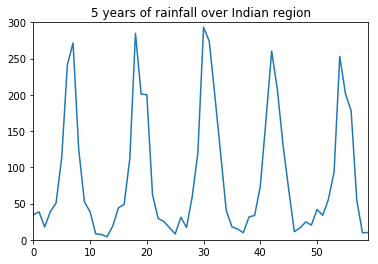

In [4]:
plt.plot(train_set[0:60])
plt.xlim(0,59)
plt.ylim(0,300)
plt.title('5 years of rainfall over Indian region')

Calculate the monthly mean for 103 years of training data. Use this mean as the monthly forecasted vallues.

In [5]:
ltm = rain_train.mean()
naive_out = np.tile(ltm,10)  # repeat ltm for 10 years, 10 years of test data

Text(0.5, 1.0, 'Naive Model')

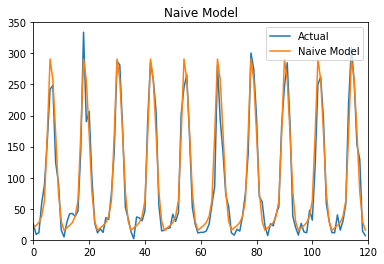

In [6]:
plt.plot(test_set,label='Actual')
plt.plot(naive_out, label='Naive Model')
plt.xlim(0,120)
plt.ylim(0,350)
plt.legend(loc=1)
plt.title("Naive Model")

In [7]:
from sklearn.metrics import mean_absolute_error
naive_error = mean_absolute_error(test_set, naive_out)
print ('Naive Mean Absolute Error :', naive_error)

Naive Mean Absolute Error : 17.04711974110032


Naive model seems to have a decent performance. It fairly mimics the actual rainfall and has a mean absolute error of about 17mm.
Often it would be difficult to surpass the performance of this common sense based naice model ! 

## Seasonal ARIMA Model

Next we will use a  Seasonal ARIMA Model (SARIMA), which is a  popular statistical method for time series forecasting. 
Interested reader can refer this excellent online book by [Rob J Hyndman](https://otexts.com/fpp2/arima.html) for more details on ARIMA models.

Model fit parameters can be obtained from auto_arima function of the [pmdarima](https://www.alkaline-ml.com/pmdarima/) package. 

In [8]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train_set, start_p=0, start_q=0,
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=5, max_q=5,  # maximum p and q
                      m=12,              # frequency of series
                      d=None,            # let model determine 'd'
                      max_d=2,
                      seasonal=True,     # Seasonality
                      start_P=0, 
                      D=None,
                      max_D = 2,
                      start_Q= 0,
                      max_P=2, max_Q=2,
                      trace=True,
                      information_criterion='aicc',
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

/home/suhas/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/suhas/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=14830.796, BIC=14841.036, Fit time=0.034 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=12183.136, BIC=12203.614, Fit time=1.717 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=13312.778, BIC=13333.257, Fit time=1.714 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=13846.523, BIC=13861.882, Fit time=0.080 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=11836.312, BIC=11861.910, Fit time=7.263 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=11933.647, BIC=11964.365, Fit time=17.357 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=11857.933, BIC=11878.412, Fit time=10.272 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=11836.718, BIC=11867.435, Fit time=14.381 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 0, 12); AIC=11836.211, BIC=11866.928, Fit time=11.383 seconds
Fit AR

SRIMA model is showing a seasonal periodicity of 12 months (as expected, the annual signal).
More details can be read in the model summary below.

In [9]:
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 1236
Model:             SARIMAX(1, 0, 3)x(1, 0, 1, 12)   Log Likelihood               -5747.504
Date:                            Mon, 23 Sep 2019   AIC                          11511.008
Time:                                    18:12:49   BIC                          11551.966
Sample:                                         0   HQIC                         11526.414
                                           - 1236                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2724      0.139      1.965      0.049       0.001       0.544
ar.L1         -0.9971      0.011   

Model diagnostics is plotted below. The residual looks like a gaussian white noise. Model seems to be fitting the data well.

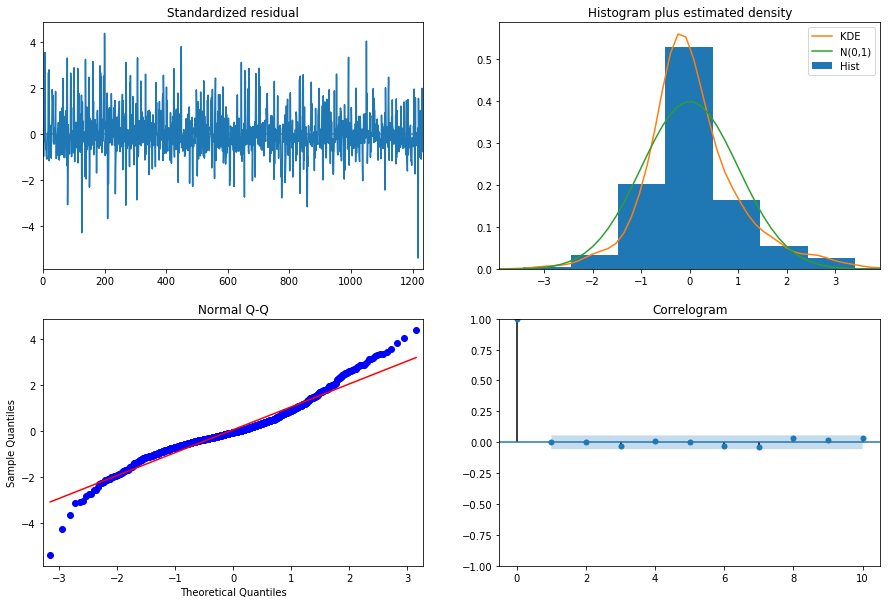

In [10]:
model.plot_diagnostics(figsize=(15,10))
plt.show()

In [11]:
sarima_out,confint = model.predict(n_periods=120, return_conf_int=True)

Text(0.5, 1.0, 'Seasonal ARIMA Model')

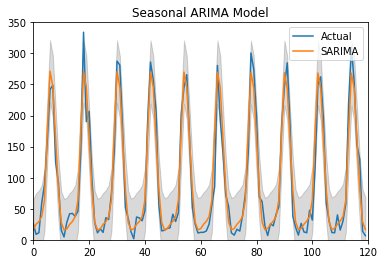

In [12]:
index = np.arange(len(test_set))
plt.plot(index, test_set,label='Actual')
plt.plot(index, sarima_out, label='SARIMA')
plt.fill_between(index,confint[:, 0],confint[:, 1], color='k', alpha=.15)
plt.xlim(0,120)
plt.ylim(0,350)
plt.legend(loc=1)
plt.title("Seasonal ARIMA Model")

Grey shaded region indicates 95% confidence interval.

In [13]:
from sklearn.metrics import mean_absolute_error
sarima_error = mean_absolute_error(test_set, sarima_out)
print ('SARIMA Mean Absolute Error :', sarima_error)

SARIMA Mean Absolute Error : 18.100912947281156


Mean absolute error of Seasonal ARIMA model is about 18mm, which is slightly worse than the Naive model.

## LSTM

Recurrent Neural Network (RNN) is widely used for time series prediction. Particularly a variant of RNN called [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is vastly popular. Here I have used a simple architecture (with not much tuning) involving 1 LSTM layer and 2 feed forward networks. More details can be found in model summary. 

In [14]:
rain_train = rain[(rain.index >= 1901) & (rain.index <= 2003)]
rain_test  = rain[(rain.index >= 2004) & (rain.index <= 2013)]

# unstack data
train_set = rain_train.stack().values
test_set  = rain_test.stack().values

train_set = train_set[:,np.newaxis]
test_set  = test_set[:,np.newaxis]

print ('Training samples : ', len(train_set))
print ('Testing samples : ', len(test_set))

Training samples :  1236
Testing samples :  120


Time series generator function is used to set up the training and test data. 
Look back period is 12 months.

In [15]:
from keras.preprocessing.sequence import TimeseriesGenerator
lookback  = 12
train_gen = TimeseriesGenerator(train_set, train_set, length=lookback, batch_size=16)

Using TensorFlow backend.


In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential()
model.add(layers.LSTM(100,activation='relu',
                      input_shape=(lookback, train_set.shape[-1])))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=Adam(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=len(train_gen)//16,
                              epochs=500)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 41,821
Trainable params: 41,821
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
4/4 [==============================] - 0s 59ms/step - loss: 110.4284
Epoch 2/500
4/4 [==============================] - 0s 6ms/step - loss: 70.1107
Epoch 3/500
4/4 [==============================] - 0s 6ms/step - loss: 71.3998
Epoch 4/500
4/4 [====

4/4 [==============================] - 0s 6ms/step - loss: 17.6558
Epoch 87/500
4/4 [==============================] - 0s 6ms/step - loss: 23.2398
Epoch 88/500
4/4 [==============================] - 0s 6ms/step - loss: 18.8317
Epoch 89/500
4/4 [==============================] - 0s 6ms/step - loss: 20.8105
Epoch 90/500
4/4 [==============================] - 0s 6ms/step - loss: 21.3631
Epoch 91/500
4/4 [==============================] - 0s 6ms/step - loss: 24.4928
Epoch 92/500
4/4 [==============================] - 0s 6ms/step - loss: 20.4094
Epoch 93/500
4/4 [==============================] - 0s 7ms/step - loss: 22.5355
Epoch 94/500
4/4 [==============================] - 0s 7ms/step - loss: 17.8466
Epoch 95/500
4/4 [==============================] - 0s 7ms/step - loss: 24.2991
Epoch 96/500
4/4 [==============================] - 0s 7ms/step - loss: 18.3747
Epoch 97/500
4/4 [==============================] - 0s 13ms/step - loss: 18.8698
Epoch 98/500
4/4 [==============================] - 

4/4 [==============================] - 0s 6ms/step - loss: 20.0230
Epoch 188/500
4/4 [==============================] - 0s 6ms/step - loss: 18.1230
Epoch 189/500
4/4 [==============================] - 0s 7ms/step - loss: 21.2795
Epoch 190/500
4/4 [==============================] - 0s 8ms/step - loss: 21.2129
Epoch 191/500
4/4 [==============================] - 0s 6ms/step - loss: 16.8740
Epoch 192/500
4/4 [==============================] - 0s 6ms/step - loss: 18.2204
Epoch 193/500
4/4 [==============================] - 0s 13ms/step - loss: 17.5130
Epoch 194/500
4/4 [==============================] - 0s 5ms/step - loss: 20.0845
Epoch 195/500
4/4 [==============================] - 0s 6ms/step - loss: 16.1978
Epoch 196/500
4/4 [==============================] - 0s 7ms/step - loss: 17.1670
Epoch 197/500
4/4 [==============================] - 0s 6ms/step - loss: 20.3948
Epoch 198/500
4/4 [==============================] - 0s 7ms/step - loss: 15.6753
Epoch 199/500
4/4 [======================

4/4 [==============================] - 0s 8ms/step - loss: 20.5744
Epoch 289/500
4/4 [==============================] - 0s 12ms/step - loss: 17.8133
Epoch 290/500
4/4 [==============================] - 0s 7ms/step - loss: 18.4502
Epoch 291/500
4/4 [==============================] - 0s 7ms/step - loss: 17.2199
Epoch 292/500
4/4 [==============================] - 0s 6ms/step - loss: 26.1757
Epoch 293/500
4/4 [==============================] - 0s 7ms/step - loss: 17.3783
Epoch 294/500
4/4 [==============================] - 0s 6ms/step - loss: 17.0780
Epoch 295/500
4/4 [==============================] - 0s 6ms/step - loss: 16.5903
Epoch 296/500
4/4 [==============================] - 0s 7ms/step - loss: 22.5534
Epoch 297/500
4/4 [==============================] - 0s 6ms/step - loss: 23.4174
Epoch 298/500
4/4 [==============================] - 0s 7ms/step - loss: 16.9796
Epoch 299/500
4/4 [==============================] - 0s 7ms/step - loss: 17.2050
Epoch 300/500
4/4 [======================

4/4 [==============================] - 0s 7ms/step - loss: 16.7263
Epoch 390/500
4/4 [==============================] - 0s 7ms/step - loss: 21.6135
Epoch 391/500
4/4 [==============================] - 0s 6ms/step - loss: 17.2387
Epoch 392/500
4/4 [==============================] - 0s 6ms/step - loss: 21.4596
Epoch 393/500
4/4 [==============================] - 0s 6ms/step - loss: 18.4295
Epoch 394/500
4/4 [==============================] - 0s 7ms/step - loss: 18.0375
Epoch 395/500
4/4 [==============================] - 0s 7ms/step - loss: 18.0552
Epoch 396/500
4/4 [==============================] - 0s 7ms/step - loss: 16.9560
Epoch 397/500
4/4 [==============================] - 0s 8ms/step - loss: 16.8648
Epoch 398/500
4/4 [==============================] - 0s 7ms/step - loss: 19.6793
Epoch 399/500
4/4 [==============================] - 0s 6ms/step - loss: 16.7573
Epoch 400/500
4/4 [==============================] - 0s 7ms/step - loss: 17.8032
Epoch 401/500
4/4 [=======================

4/4 [==============================] - 0s 6ms/step - loss: 17.9267
Epoch 491/500
4/4 [==============================] - 0s 6ms/step - loss: 18.3428
Epoch 492/500
4/4 [==============================] - 0s 7ms/step - loss: 19.5697
Epoch 493/500
4/4 [==============================] - 0s 6ms/step - loss: 21.6526
Epoch 494/500
4/4 [==============================] - 0s 6ms/step - loss: 18.4040
Epoch 495/500
4/4 [==============================] - 0s 7ms/step - loss: 18.3575
Epoch 496/500
4/4 [==============================] - 0s 7ms/step - loss: 19.6583
Epoch 497/500
4/4 [==============================] - 0s 6ms/step - loss: 19.0009
Epoch 498/500
4/4 [==============================] - 0s 6ms/step - loss: 21.8905
Epoch 499/500
4/4 [==============================] - 0s 6ms/step - loss: 20.2692
Epoch 500/500
4/4 [==============================] - 0s 7ms/step - loss: 20.5302


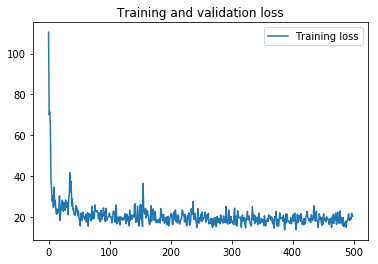

In [17]:
loss = history.history['loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss,  label='Training loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [18]:
test_set_append = (np.append(train_set[-12:],test_set))[:,np.newaxis]
test_gen = TimeseriesGenerator(test_set_append, test_set_append, length=lookback, batch_size=16)

In [19]:
pred = model.predict_generator(test_gen)

Text(0.5, 1.0, 'LSTM')

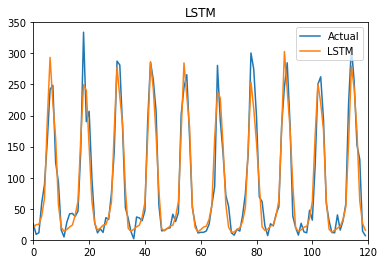

In [20]:
plt.plot(test_set,label='Actual')
plt.plot(pred, label='LSTM')
plt.xlim(0,120)
plt.ylim(0,350)
plt.legend(loc=1)
plt.title("LSTM")

In [21]:
from sklearn.metrics import mean_absolute_error
lstm_error = mean_absolute_error(test_set, pred)
print ('LSTM Mean Absolute Error :', lstm_error)

LSTM Mean Absolute Error : 19.25377242724101


LSTM also under performs the naive model. Perhaps further tuning of the model could help boost its performance. 
But I guess the past values of the rainfall is not a good indicator for the future. This is one of the case where a common sense based naive model performs better than the others.